In [1]:
import sys; sys.path.append('..')
import inflation, numpy as np, importlib, fd_validation, visualization, parametric_pillows, wall_generation
from numpy.linalg import normcd ~/Inflatables/python
jupyter lab

import MeshFEM, parallelism, benchmark, utils

In [2]:
parallelism.set_max_num_tbb_threads(4)

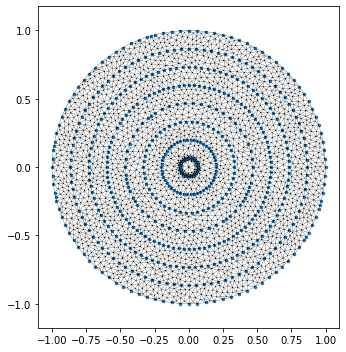

In [4]:
m, fuseMarkers, fuseEdges = wall_generation.triangulate_channel_walls(*parametric_pillows.concentricCircles(8, 50), 0.001)
visualization.plot_2d_mesh(m, pointList=np.where(np.array(fuseMarkers) == 1)[0], width=5, height=5)

In [5]:
isheet = inflation.InflatableSheet(m, np.array(fuseMarkers) != 0)

In [6]:
import py_newton_optimizer
opts = py_newton_optimizer.NewtonOptimizerOptions()
opts.useIdentityMetric = True
opts.beta = 1e-4
opts.gradTol = 1e-10

In [7]:
from tri_mesh_viewer import TriMeshViewer
viewer = TriMeshViewer(isheet, width=768, height=640)
viewer.showWireframe(True)
viewer.show()

Renderer(camera=PerspectiveCamera(aspect=1.2, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

In [8]:
import time, vis
benchmark.reset()
isheet.setUseTensionFieldEnergy(True)
isheet.setUseHessianProjectedEnergy(False)
isheet.pressure = 20 * 3.75
opts.niter = 200
framerate = 5 # Update every 5 iterations
def cb(it):
    if it % framerate == 0:
        viewer.update()
cr = inflation.inflation_newton(isheet, isheet.rigidMotionPinVars, opts, callback=cb)
benchmark.report()

InflatableSheet setVars	0.000763178	1
Newton iterations	16.237	1
    InflatableSheet energy	0.000100136	1
    Newton iterate	16.2211	147
        Backtracking	0.277556	146
            InflatableSheet energy	0.0418227	208
            InflatableSheet setVars	0.231776	208
        Compute descent direction	14.9595	146
            newton_step	14.9592	146
                Newton solve	13.6141	179
                    CHOLMOD Numeric Factorize	13.1249	178
                    Solve	0.376724	147
                        CHOLMOD Backsub	0.308644	146
                        CHOLMOD Numeric Factorize	0.00966501	1
                        CHOLMOD Symbolic Factorize	0.051903	1
                hessEval	1.3085	146
                largestMagnitudeEigenvalue	0.0199814	2
        Preamble	0.948969	147
            Callback	0.815621	147
            InflatableSheet energy	0.0413468	147
            InflatableSheet gradient	0.0822206	147
Full time	16.246


In [9]:
viewer.update(scalarField=utils.getStrains(isheet)[:, 0])

### Repeat the inflation, this time recording it to a video
Requires `MeshFEM`'s `OffscreenRenderer` to be successfully built.

In [10]:
isheet = inflation.InflatableSheet(m, np.array(fuseMarkers) != 0)

from tri_mesh_viewer import OffscreenTriMeshViewer
oview = OffscreenTriMeshViewer(isheet, width=768, height=640, wireframe=True)

benchmark.reset()
opts.niter=1000
oview.recordStart('cc_inflate.mp4')
isheet.pressure = 20 * 3.75
cr = inflation.inflation_newton(isheet, isheet.rigidMotionPinVars, opts,
                                callback=lambda it: oview.update())
benchmark.report()
oview.recordStop()

InflatableSheet setVars	0.00117779	1
Newton iterations	25.6548	1
    InflatableSheet energy	0.000132084	1
    Newton iterate	25.6542	147
        Backtracking	0.368837	146
            InflatableSheet energy	0.0320959	217
            InflatableSheet setVars	0.332556	217
        Compute descent direction	13.1111	146
            newton_step	13.1108	146
                Newton solve	11.6726	179
                    CHOLMOD Numeric Factorize	11.2631	178
                    Solve	0.313499	147
                        CHOLMOD Backsub	0.258935	146
                        CHOLMOD Numeric Factorize	0.00338984	1
                        CHOLMOD Symbolic Factorize	0.0450101	1
                hessEval	1.41791	146
                largestMagnitudeEigenvalue	0.0142329	2
        Preamble	12.1317	147
            Callback	12.0342	147
            InflatableSheet energy	0.0249379	147
            InflatableSheet gradient	0.0609601	147
Full time	25.6811


0.13807716428008876


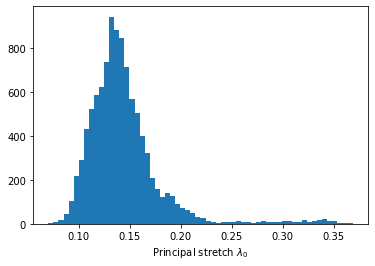

In [11]:
# Some basic statistics for the deformation
from matplotlib import pyplot as plt
strains = utils.getStrains(isheet)[:, 0]
plt.hist(strains, 60);
plt.xlabel('Principal stretch $\\lambda_0$')
print(np.median(strains))

### Analyze curvature of the inflated surface

In [12]:
isa = inflation.InflatedSurfaceAnalysis(isheet)
curvature = isa.curvature()
metric = isa.metric()

In [13]:
import matplotlib, vis
from tri_mesh_viewer import TriMeshViewer
isurf = isa.inflatedSurface()
metric_vf = vis.fields.VectorField(isurf, metric.sigma_2[:, None] * metric.left_stretch, vmin=0, vmax=1.0,
                                   align=vis.fields.VectorAlignment.CENTER, colormap=matplotlib.cm.viridis,
                                   glyph=vis.fields.VectorGlyph.CYLINDER)

viewer2 = TriMeshViewer(isurf, width=768, height=640, scalarField=vis.fields.ScalarField(isurf, curvature.meanCurvature(), colormap=matplotlib.cm.coolwarm), vectorField=metric_vf)
viewer2.showWireframe()
viewer2.show()

Renderer(camera=PerspectiveCamera(aspect=1.2, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …